In [ ]:
import time
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
from qutip import *

from plotstyle import init_style, COLORS, LINE_STYLES
init_style()

from project_config import SCRIPTS_DIR
from qspectro2d.utils import BOLTZMANN, HBAR
from qspectro2d.config import create_base_sim_oqs
from qspectro2d.core.bath_system import extract_bath_parameters
from qspectro2d.core.atom_bath_class import AtomBathCoupling
from qspectro2d.core.bath_system.bath_fcts import power_spectrum_func_paper, power_spectrum_func_ohmic, extract_bath_parameters


In [2]:
config_path = SCRIPTS_DIR / "config.yaml"
sim_oqs, time_cut = create_base_sim_oqs(config_path=str(config_path) if config_path else None)

🔧 Base simulation created from config (overrides applied early).
🔍 Validating solver...


c:\Users\leopo\anaconda3\envs\master_env\Lib\site-packages\qutip\solver\brmesolve.py:173: FutureWarning: c_ops, e_ops, args and options will be keyword only from qutip 5.3
  warnings.warn(
c:\Users\leopo\anaconda3\envs\master_env\Lib\site-packages\qutip\utilities.py:55: RuntimeWarning: overflow encountered in exp
  result[non_zero] = 1 / (np.exp(w[non_zero] / w_th) - 1)


############################################################
✅ Solver validation worked: Evolution becomes unphysical at (inf × t_max)


In [ ]:
times = sim_oqs.times_local

H = sim_oqs.evo_obj # QobjEvo
t0 = times[0]
t_peak = sim_oqs.laser.pulse_peak_times[0]

# TODO build the redfield tensor for both time points to check weather or not it is time dependent
H_0 = H(t0)
H_peak = H(t_peak)
R_t0 = bloch_redfield_tensor(H_0, sim_oqs.decay_channels)
R_tpeak = bloch_redfield_tensor(H_peak, sim_oqs.decay_channels)

: 

: 

: 

In [ ]:
print(R_t0[1], R_tpeak[1])

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[-9.99999990e-01 -1.40084321e-04]
 [-1.40084321e-04  9.99999990e-01]] Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[-0.99997955  0.00639518]
 [ 0.00639518  0.99997955]]


: 

: 

: 

(<Figure size 800x600 with 2 Axes>, <Axes3D: >)

c:\Users\leopo\anaconda3\envs\master_env\Lib\site-packages\IPython\core\events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
c:\Users\leopo\anaconda3\envs\master_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


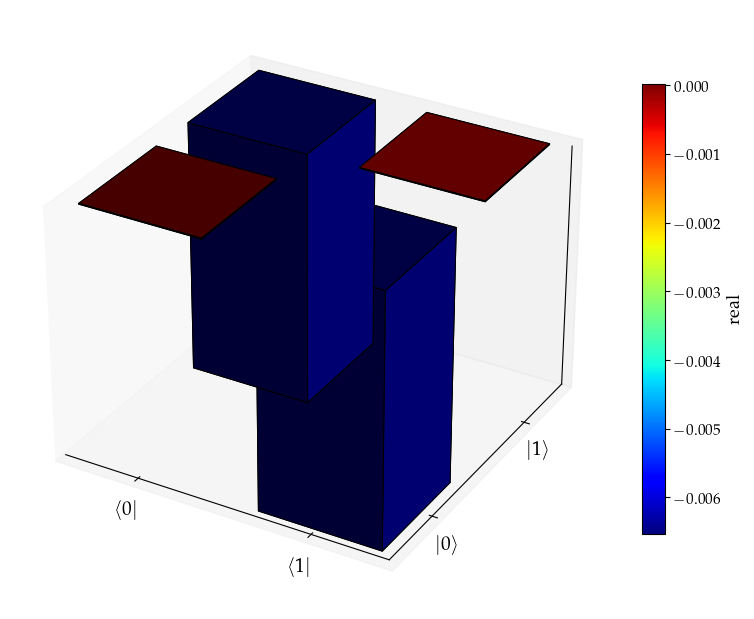

: 

: 

: 

In [ ]:
# xbasis 0<-0, 0<-1, 0<-2, 0<-3, 1<-0, 1<-1, 1<-2, 1<-3, 2<-0, 2<-1, 2<-2, 2<-3, 3<-0, 3<-1, 3<-2, 3<-3
dims = sim_oqs.system.dimension
xbasis = [f"{i},{j}" for i in range(dims) for j in range(dims)]
ybasis = xbasis.copy()
#matrix_histogram(R_t0[0] - R_tpeak[0], bar_style="phase", x_basis=xbasis, y_basis=ybasis)
matrix_histogram(R_t0[1] - R_tpeak[1], bar_style="real")

In [ ]:
print(isinstance(sim_oqs.bath, BosonicEnvironment))
w0 = sim_oqs.system.frequencies_fs[0]
print(extract_bath_parameters(sim_oqs.bath, w0=w0))

True
{'T': 0.01, 'temp': 0.01, 'tag': 'ohmic', 'S(0)': 0.0002, 'S(w0)': 0.058488730380650784, 'alpha': 0.01, 'wc': 100.0, 'cutoff': 100.0, 's': 1.0}


: 

: 

: 

c:\Users\leopo\anaconda3\envs\master_env\Lib\site-packages\qutip\utilities.py:55: RuntimeWarning: overflow encountered in exp
  result[non_zero] = 1 / (np.exp(w[non_zero] / w_th) - 1)
C:\Users\leopo\AppData\Local\Temp\ipykernel_27260\1967889655.py:79: RuntimeWarning: overflow encountered in exp
  n_thermal = 1 / (np.exp(HBAR * w_positive / kT) - 1)


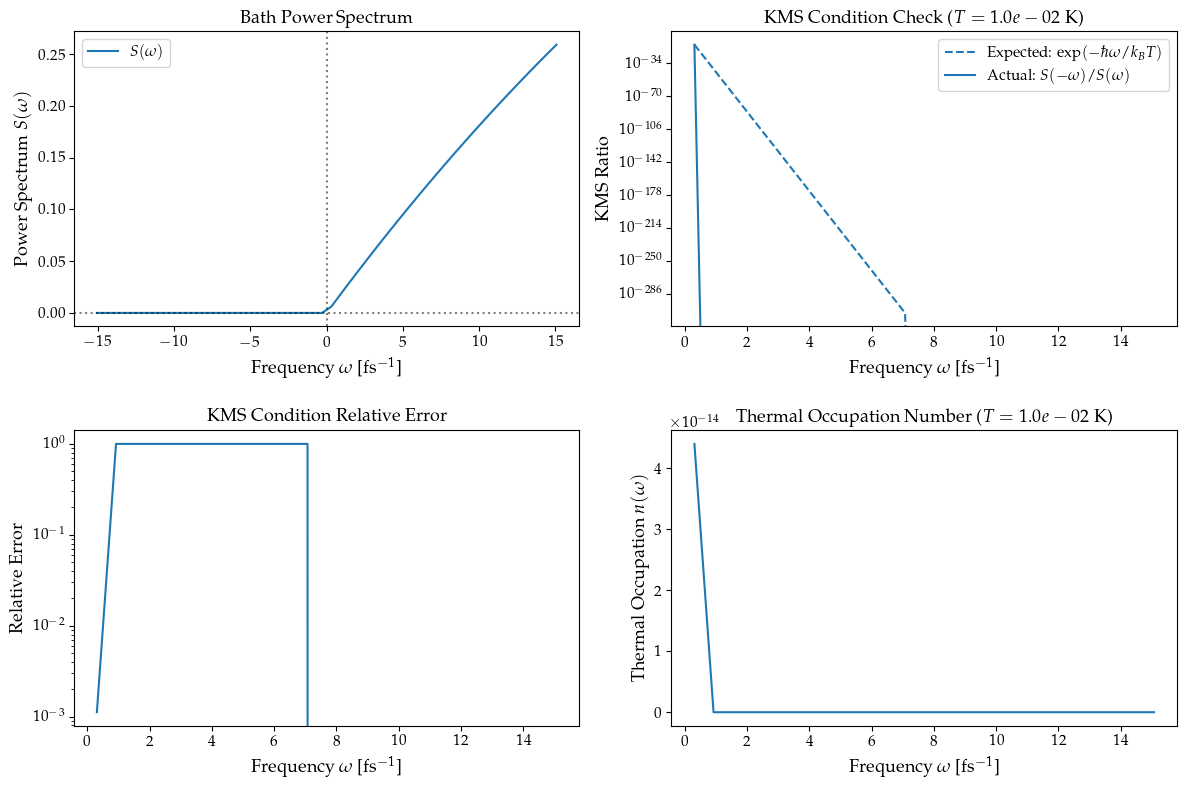


DETAILED BALANCE / KMS CONDITION CHECK
Bath temperature: 1.00e-02 K
Thermal energy kT: 1.00e-02 eV
Maximum relative error: 1.00e+00
Mean relative error: 4.40e-01
❌ KMS condition NOT satisfied (error > 1e-3)


: 

: 

: 

In [ ]:
bath = sim_oqs.bath
w = np.linspace(-5 * w0, 5 * w0, 50)
# DETAILED BALANCE / KMS CONDITION CHECK
def check_detailed_balance_condition(
    bath: BosonicEnvironment, 
    w_range: np.ndarray
) -> None:
    """
    Check if the power spectrum satisfies the detailed balance (KMS) condition.
    
    The KMS condition states: S(-ω) = S(ω) * exp(-ħω/kT)
    For zero temperature: S(-ω) = 0 for ω > 0
    """
    
    ### Bath parameters
    S          = bath.power_spectrum
    kT         = BOLTZMANN * bath.T  # thermal energy
    
    ### Evaluate power spectrum at positive and negative frequencies
    S_positive = np.array([S(w) for w in w_range if w > 0])
    S_negative = np.array([S(-w) for w in w_range if w > 0])
    w_positive = w_range[w_range > 0]
    
    ### Expected ratio from KMS condition
    if bath.T > 1e-10:  # finite temperature
        kms_ratio_expected = np.exp(-HBAR * w_positive / kT)
    else:  # zero temperature limit
        kms_ratio_expected = np.zeros_like(w_positive)
    
    ### Actual ratio from power spectrum
    with np.errstate(divide='ignore', invalid='ignore'):
        kms_ratio_actual = S_negative / S_positive
        kms_ratio_actual = np.where(S_positive == 0, 0, kms_ratio_actual)
    
    ### Plot comparison
    plt.figure(figsize=(12, 8))
    
    ### Power spectrum vs frequency
    plt.subplot(2, 2, 1)
    plt.plot(w_range, [S(w) for w in w_range], 
             label=r'$S(\omega)$', color='C0', linestyle='solid')
    plt.axhline(y=0, color='k', linestyle='dotted', alpha=0.5)
    plt.axvline(x=0, color='k', linestyle='dotted', alpha=0.5)
    plt.xlabel(r'Frequency $\omega$ [fs$^{-1}$]')
    plt.ylabel(r'Power Spectrum $S(\omega)$')
    plt.title(r'Bath Power Spectrum')
    plt.legend()
    
    ### KMS ratio comparison
    plt.subplot(2, 2, 2)
    plt.plot(w_positive, kms_ratio_expected, 
             label=r'Expected: $\exp(-\hbar\omega/k_BT)$', 
             color='C1', linestyle='dashed')
    plt.plot(w_positive, kms_ratio_actual, 
             label=r'Actual: $S(-\omega)/S(\omega)$', 
             color='C0', linestyle='solid')
    plt.xlabel(r'Frequency $\omega$ [fs$^{-1}$]')
    plt.ylabel(r'KMS Ratio')
    plt.title(f'KMS Condition Check ($T = {bath.T:.1e}$ K)')
    plt.legend()
    plt.yscale('log')
    
    ### Relative error
    plt.subplot(2, 2, 3)
    with np.errstate(divide='ignore', invalid='ignore'):
        relative_error = np.abs(kms_ratio_actual - kms_ratio_expected) / np.abs(kms_ratio_expected)
        relative_error = np.where(kms_ratio_expected == 0, 
                                np.abs(kms_ratio_actual), relative_error)
    
    plt.plot(w_positive, relative_error, color='C2', linestyle='solid')
    plt.xlabel(r'Frequency $\omega$ [fs$^{-1}$]')
    plt.ylabel(r'Relative Error')
    plt.title(r'KMS Condition Relative Error')
    plt.yscale('log')
    
    ### Thermal occupation number
    plt.subplot(2, 2, 4)
    if bath.T > 1e-10:
        n_thermal = 1 / (np.exp(HBAR * w_positive / kT) - 1)
        plt.plot(w_positive, n_thermal, color='C3', linestyle='solid')
        plt.xlabel(r'Frequency $\omega$ [fs$^{-1}$]')
        plt.ylabel(r'Thermal Occupation $n(\omega)$')
        plt.title(f'Thermal Occupation Number ($T = {bath.T:.1e}$ K)')
    else:
        plt.text(0.5, 0.5, 'Zero Temperature\n($T \\rightarrow 0$)', 
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Thermal Occupation Number')
    
    plt.tight_layout()
    plt.show()
    
    ### Print numerical assessment
    print(f"\n{'='*50}")
    print(f"DETAILED BALANCE / KMS CONDITION CHECK")
    print(f"{'='*50}")
    print(f"Bath temperature: {bath.T:.2e} K")
    print(f"Thermal energy kT: {kT:.2e} eV")
    
    if bath.T > 1e-10:
        max_error = np.max(relative_error[np.isfinite(relative_error)])
        mean_error = np.mean(relative_error[np.isfinite(relative_error)])
        print(f"Maximum relative error: {max_error:.2e}")
        print(f"Mean relative error: {mean_error:.2e}")
        
        if max_error < 1e-6:
            print("✅ KMS condition is satisfied (error < 1e-6)")
        elif max_error < 1e-3:
            print("⚠️  KMS condition approximately satisfied (error < 1e-3)")
        else:
            print("❌ KMS condition NOT satisfied (error > 1e-3)")
    else:
        zero_temp_satisfied = np.all(S_negative < 1e-10)
        print(f"Zero temperature condition S(-ω) ≈ 0: {zero_temp_satisfied}")
        if zero_temp_satisfied:
            print("✅ Zero temperature KMS condition satisfied")
        else:
            print("❌ Zero temperature KMS condition NOT satisfied")

check_detailed_balance_condition(bath, w)

In [ ]:
a_ops = sim_oqs.decay_channels
H = sim_oqs.H0_diagonalized
dim = sim_oqs.system.dimension
omegaij = np.zeros((dim, dim))
for i in range(dim):
    for j in range(dim):
        omegaij[i, j] = sim_oqs.system.omega_ij(i, j)
skew = omegaij
S = a_ops[0][1].power_spectrum
Sij = np.zeros((dim, dim))
for i in range(dim):
    for j in range(dim):
        Sij[i, j] = S(omegaij[i, j])
skew, Sij

(array([[ 0.        , -3.01391833],
        [ 3.01391833,  0.        ]]),
 array([[ 0.0002    , -0.        ],
        [ 0.05848873,  0.0002    ]]))

: 

: 

: 

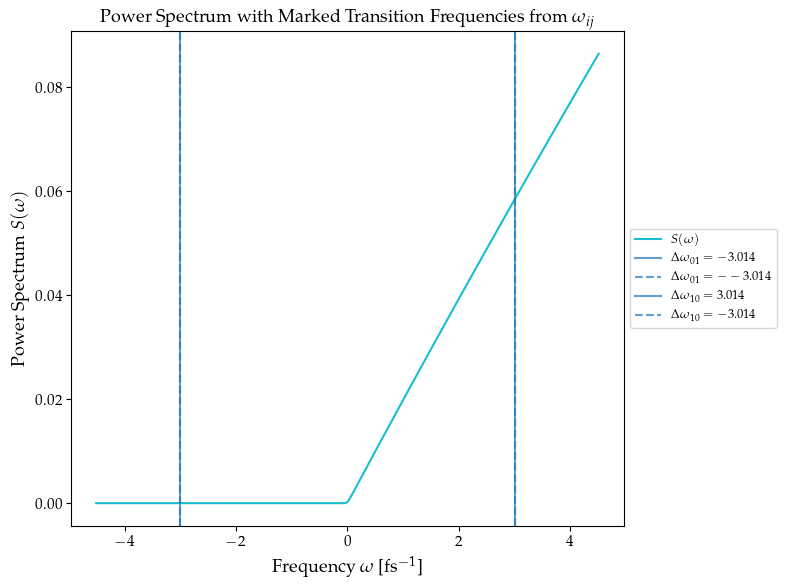

: 

: 

: 

In [ ]:
max = np.max(np.abs(omegaij))
w_extended = np.linspace(-1.5 * max, 1.5 * max, 200)  # Extend to cover up to 1.5 * max |omegaij|

plt.figure()
# Plot the power spectrum
plt.plot(w_extended, S(w_extended), label=r'$S(\omega)$', color=COLORS[-1], linestyle=LINE_STYLES[0])

unique_pairs = [(i, j) for i in range(dim) for j in range(i + 1, dim)]
pair_to_color = {pair: COLORS[k % len(COLORS)] for k, pair in enumerate(unique_pairs)}
for i in range(dim):
    for j in range(dim):
        if i != j:
            omega = omegaij[i, j]
            pair = tuple(sorted((i, j)))
            color = pair_to_color[pair]
            plt.axvline(omega, color=color, linestyle=LINE_STYLES[0], alpha=0.7, label=f'$\Delta \omega_{{{i}{j}}} = {omega:.3f}$')
            plt.axvline(-omega, color=color, linestyle=LINE_STYLES[1], alpha=0.7, label=f'$\Delta \omega_{{{i}{j}}} = -{omega:.3f}$')
plt.xlabel(r'Frequency $\omega$ [fs$^{-1}$]')
plt.ylabel(r'Power Spectrum $S(\omega)$')
plt.title(r'Power Spectrum with Marked Transition Frequencies from $\omega_{ij}$')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')
plt.show()

In [ ]:
args = extract_bath_parameters(sim_oqs.bath)
args["temp"] = args["T"]
args["cutoff"] = args["wc"]

print("bath at 0", args["S(0)"])
P_ohmic_0 = power_spectrum_func_ohmic(0, **args)
args["alpha"] = args["alpha"] * args["wc"]  # Convert back to original alpha definition
P_0 = power_spectrum_func_paper(0, **args)
P_0, P_ohmic_0

bath at 0 0.0002


(0.0002, 0.0002)

: 

: 

: 

In [ ]:
sb = sim_oqs.sb_coupling
S(0), sb.paper_Gamma_ij(1,0)


ValueError: theta is only defined for n_atoms == 2

: 

: 

: 

In [ ]:
R_paper = redfield_paper(sim_oqs)
H_liouvillian = liouvillian(H)
R_paper = H_liouvillian + R_paper
R_paper

Quantum object: dims=[[[4], [4]], [[4], [4]]], shape=(16, 16), type='super', dtype=Dense, isherm=False
Qobj data =
[[ 0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j         -8.81288951e-06+0.17654591j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j          0.00000000e+00+0.j
  -1.5901

: 

: 

: 

Quantum object: dims=[[[4], [4]], [[4], [4]]], shape=(16, 16), type='super', dtype=Dense, isherm=False
Qobj data =
[[-7.76926038e-14+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          3.61136279e-06+0.j        ]
 [ 0.00000000e+00+0.j         -7.81651662e-07-0.08827295j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j          0.00000000e+00+0.j
  -7.8165

(<Figure size 800x600 with 2 Axes>, <Axes3D: >)

c:\Users\leopo\anaconda3\envs\master_env\Lib\site-packages\IPython\core\events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
c:\Users\leopo\anaconda3\envs\master_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


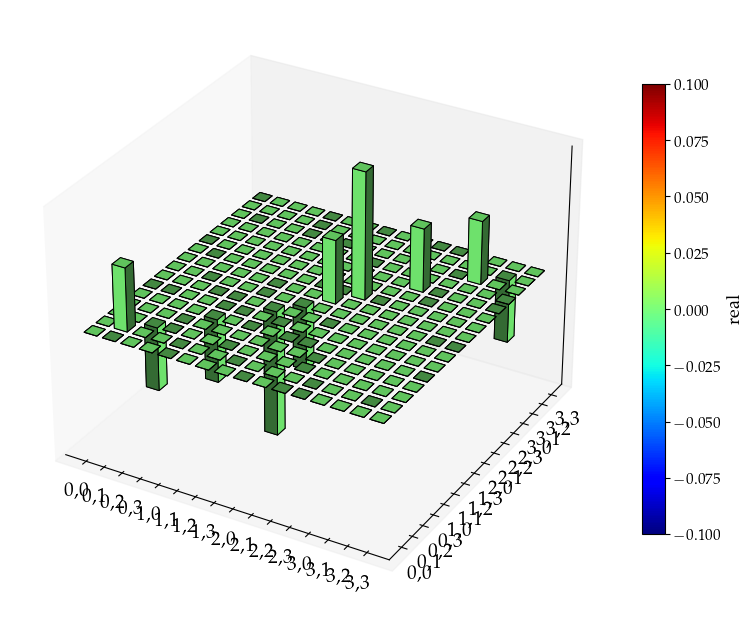

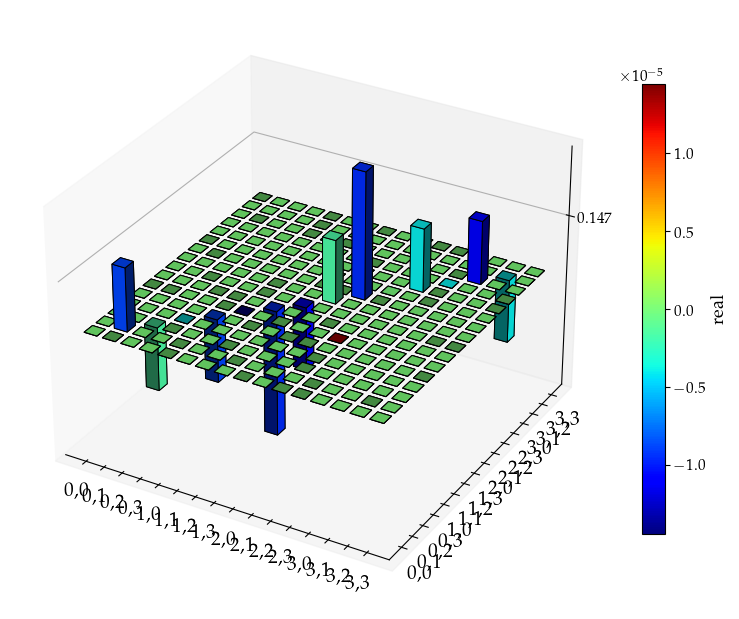

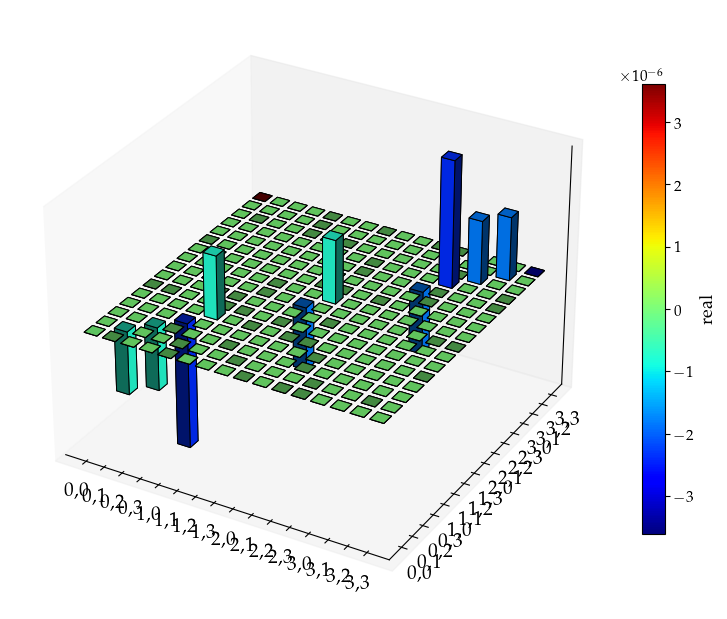

: 

: 

: 

In [ ]:
# xbasis 0<-0, 0<-1, 0<-2, 0<-3, 1<-0, 1<-1, 1<-2, 1<-3, 2<-0, 2<-1, 2<-2, 2<-3, 3<-0, 3<-1, 3<-2, 3<-3
dims = sim_oqs.system.dimension
xbasis = [f"{i},{j}" for i in range(dims) for j in range(dims)]
ybasis = xbasis.copy()
matrix_histogram(H_liouvillian, bar_style="img", x_basis=xbasis, y_basis=ybasis)
matrix_histogram(R_paper, bar_style="img", x_basis=xbasis, y_basis=ybasis)

# now with qutip
R_qutip = bloch_redfield_tensor(H, a_ops=[a_ops[0]])
print(R_qutip[0])
matrix_histogram(R_qutip[0], bar_style="img", x_basis=xbasis, y_basis=ybasis)